# Static contract Type

Static contracts are defined as arrays of intervals. Each interval is associated with a scalar value sent via a wire.

In [1]:
# References: 
# Algebraic Dynamics: https://github.com/AlgebraicJulia/AlgebraicDynamics.jl/blob/master/src/dwd_dynam.jl
# Catlab: https://github.com/AlgebraicJulia/Catlab.jl/blob/master/src/wiring_diagrams/Directed.jl
# Interval sets: https://github.com/JuliaMath/IntervalSets.jl

In [2]:
using Catlab.WiringDiagrams
using Catlab.Graphics
using Catlab.Graphics.Graphviz
using IntervalSets 

In [3]:
include("StaticContracts.jl")
using .StaticContracts

### 1. Composite contract of two boxes:
Consider the simple case of two boxes. There are two ways these boxes can connected with each other. They can be connected in _series_ or they can be connected in _parallel_. 

In their isolated state, each box has a single contract for each wire entering and exiting the box:  

Box1: C1 &rarr; _Xin_ x _Xout_  
Box2: C2 &rarr; _Yin_ x _Yout_  

See p.14 of [Categorical Semantics of Cyber-Physical Systems Theory](https://arxiv.org/pdf/2010.08003.pdf) for the rules of these compositions. 

In [4]:
box1 = StaticContracts.StaticContract{Float64}( [ Interval{:open, :closed}(1..2) ], [2..Inf] )

StaticContract( (1,2] × [2.0,∞) )

In [5]:
box2 = StaticContracts.StaticContract{Float64}( [-Inf..Inf], [-Inf..Inf] )

StaticContract( ℝ × ℝ )

__Series composition:__
In this configuration, the output of one box is connected to the input of the other box. The results is the following composition:  

C<sub>Series</sub> &rarr; C1 X C2 &rarr; (_Xin_ x _Xout_) x (_Yin_ x _Yout_) &rarr; _Xin_ x _Yout_

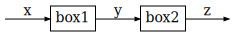

In [6]:
system = WiringDiagram([:x], [:z])

xbox = add_box!(system, Box(:box1, [:x], [:y]))
ybox = add_box!(system, Box(:box2, [:y], [:z]))

add_wires!(system, [  
  (input_id(system),1) => (xbox,1),  
  (xbox,1) => (ybox,1),
  (ybox,1) => (output_id(system),1)
])

to_graphviz(system, orientation=LeftToRight, labels=true)

In [7]:
oapply(system, [box1, box2])

StaticContract( (1,2] × ℝ )

__Parallel Composition:__
In this configuration, the boxes are combined to form a larger system with additional inputs and outputs. The resulting composition is:

C<sub>Parallel</sub> &rarr; C1 X C2 &rarr; (_Xin_ x _Xout_) x (_Yin_ x _Yout_) &rarr; (_Xin_ x _Yin_) x (_Xout_ x _Yout_)

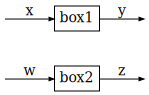

In [8]:
system = WiringDiagram([:x, :w], [:y, :z])

xbox = add_box!(system, Box(:box1, [:x], [:y]))
ybox = add_box!(system, Box(:box2, [:w], [:z]))

add_wires!(system, [  
  (input_id(system),1) => (xbox,1), 
  (input_id(system),2) => (ybox,1),
  (xbox,1) => (output_id(system),1),
  (ybox,1) => (output_id(system),2)
])

to_graphviz(system, orientation=LeftToRight, labels=true)

In [9]:
oapply(system, [box1, box2])

StaticContract( (1,2] × ℝ × [2.0,∞) × ℝ )

### 2. Composite contract from autonomy talks

This diagram was taken from the example shown in:  [Autonomy Talks - Georgios Bakirtzis: Compositional Cyber-Physical Systems Theory](https://www.youtube.com/watch?v=Ot9szu3HZ8g)

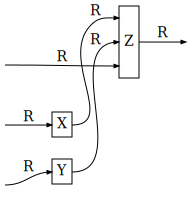

In [10]:
system = WiringDiagram([:R, :R, :R], [:R])

xbox = add_box!(system, Box(:X, [:R], [:R]))
ybox = add_box!(system, Box(:Y, [:R], [:R]))
zbox = add_box!(system, Box(:Z, [:R, :R, :R], [:R]))

add_wires!(system, [   
    (xbox,1) => (zbox,1),
    (ybox,1) => (zbox,2),
    (zbox,1) => (output_id(system),1),
    (input_id(system),2) => (xbox,1), 
    (input_id(system),3) => (ybox,1), 
    (input_id(system),1) => (zbox,3),   
])

to_graphviz(system, orientation=LeftToRight, labels=true)

In [11]:
# Contracts for each box
rx = StaticContract{Float64}( [4..5], [4..5] )
ry = StaticContract{Float64}( [8..9], [8..9] )
rz = StaticContract{Float64}( [3..5, 7..9, -Inf..Inf], [0..1] )

StaticContract( [3.0,5.0] × [7.0,9.0] × ℝ × [0,1] )

In [12]:
# Net contract for system
oapply(system, Dict(:X=>rx, :Y=>ry, :Z=>rz)) 

StaticContract( [4,5] × [8,9] × ℝ × [0,1] )

### 3. Composite contracts for UAV system

Arbitrary contracts for the UAV example in p.22 of Categorical semantics (use the link of example 1).

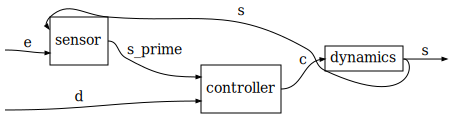

In [13]:
UAV = WiringDiagram([:e,:d], [:s])

sensor     = add_box!(UAV, Box(:sensor    , [:s, :e]      , [:s_prime]))
controller = add_box!(UAV, Box(:controller, [:s_prime, :d], [:c]))
dynamics   = add_box!(UAV, Box(:dynamics  , [:c]          , [:s]))

add_wires!(UAV, [     
  (input_id(UAV),1) => (sensor,2),
  (input_id(UAV),2) => (controller,2),
  (sensor,1) => (controller,1),
  (controller,1) => (dynamics,1),
  (dynamics,1) => (sensor,1),
  (dynamics,1) => (output_id(UAV),1)
])

to_graphviz(UAV, orientation=LeftToRight, labels=true)

In [14]:
# Define the contracts for each box
s_machine = StaticContract{Float64}([-Inf..Inf,  0.0..100.0], # Inputs -> [:s, :e]      
                                    [-Inf..Inf])              # Outputs -> [:s_prime]

c_machine = StaticContract{Float64}([-Inf..Inf,  -20.0..20.0],# Inputs -> [:s_prime, :d]
                                    [-Inf..Inf])              # Outputs -> [:c]

d_machine = StaticContract{Float64}([-Inf..Inf],     # Inputs -> [:c]
                                    [-35.0..35.0])   # Outputs -> [:s]

StaticContract( ℝ × [-35.0,35.0] )

In [15]:
# compose system
comp = oapply(UAV, Dict(:sensor => s_machine, 
                        :controller => c_machine, 
                        :dynamics => d_machine))

StaticContract( [0.0,100.0] × [-20.0,20.0] × [-35.0,35.0] )

### 4. Failure states
There are a few constraints that must be enforced between the boxes to ensure valid contract compositions.

1. Incompatible contracts:   
This occurs when the contract of a souce is defined on an interval that lies outside the target contract. That is, the the source has behavior that is undefined for the target. 

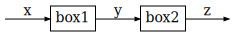

In [16]:
system = WiringDiagram([:x], [:z])

xbox = add_box!(system, Box(:box1, [:x], [:y]))
ybox = add_box!(system, Box(:box2, [:y], [:z]))

add_wires!(system, [  
  (input_id(system),1) => (xbox,1),  
  (xbox,1) => (ybox,1),
  (ybox,1) => (output_id(system),1)
])

to_graphviz(system, orientation=LeftToRight, labels=true)

In [17]:
box1 = StaticContract{Float64}( [1.0..2.0], [2.0..Inf] )
box2 = StaticContract{Float64}( [-Inf..5.0], [-Inf..Inf] )
oapply(system, [box1, box2])

WARNING! undefined contract between box1 (id=1) and box2 (id=2) at wire "y":
                    [2.0,∞) ∩ (-∞,5.0] ≠ [2.0,∞)


StaticContract( [1.0,2.0] × ℝ )

2. Incompatible contracts:  
The source contract must have at least partial overlap with the target contract. If this does not occur, there is no defined behavior that the composition cannot occur (nothing to compose).

In [18]:
box1 = StaticContract{Float64}( [Interval{:open, :closed}(1.0..2.0)], [2.0..4.0] )
box2 = StaticContract{Float64}( [-Inf..1.0], [-Inf..Inf] )
oapply(system, [box1, box2])

LoadError: Incompatible contract between box1 (id=1) and box2 (id=2) at wire "y":
                    [2.0,4.0] ∩ (-∞,1.0] = ∅

3. Dissimilar number of inputs and outputs:  
The output contracts of a box must connect with another box or pass through as an output of the system.

In [19]:
box1 = StaticContract{Float64}( [1.0..2.0], [2.0..Inf, -5.0..5.0] )  # Two outputs 
box2 = StaticContract{Float64}( [-Inf..Inf], [-Inf..Inf] )           # one input
oapply(system, [box1, box2])

LoadError: number of ports do not match number of contracts at box1 (id=1)

4. Dissimilar wire names:  
The name of an outgoing wire must match the name of an ingoing wire. This constraint makes it easier to identify faulty compositions.

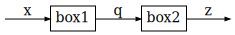

In [20]:
system = WiringDiagram([:x], [:z])

# Boxes have dissimilar wire names
xbox = add_box!(system, Box(:box1, [:x], [:q]))  # Output wire: q
ybox = add_box!(system, Box(:box2, [:y], [:z]))  # Input wire: y

add_wires!(system, [  
  (input_id(system),1) => (xbox,1),  
  (xbox,1) => (ybox,1),
  (ybox,1) => (output_id(system),1)
])

to_graphviz(system, orientation=LeftToRight, labels=true)

In [21]:
box1 = StaticContract{Float64}( [1.0..2.0], [2.0..Inf] )
box2 = StaticContract{Float64}( [-Inf..Inf], [-Inf..Inf] )
oapply(system, [box1, box2])

LoadError: wire "y" of box1 (id=1) does not match wire "q" of box2 (id=2)